# Classification tree demo using the iris dataset

The purpose of this notebook is to accompany this blog post, demonstrating the usage of an implementation of a classification tree.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# home-grown tree class and Gini as metric
from tree import Tree, Gini

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# set seed for sklearn train_test_split
np.random.seed(1234)

## Load in the iris dataset

We will use the iris dataset for demonstration purposes. On the slim chance that anyone hasnt seen this dataset before, it is a classic dataset for clustering and classification. Sepal length, sepal width, petal length and petal width are recorded for 150 observations of three species of iris (flowers)

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
iris_df = pd.DataFrame(X, columns = ['sl','sw','pl','pw'])
iris_df['species'] = y

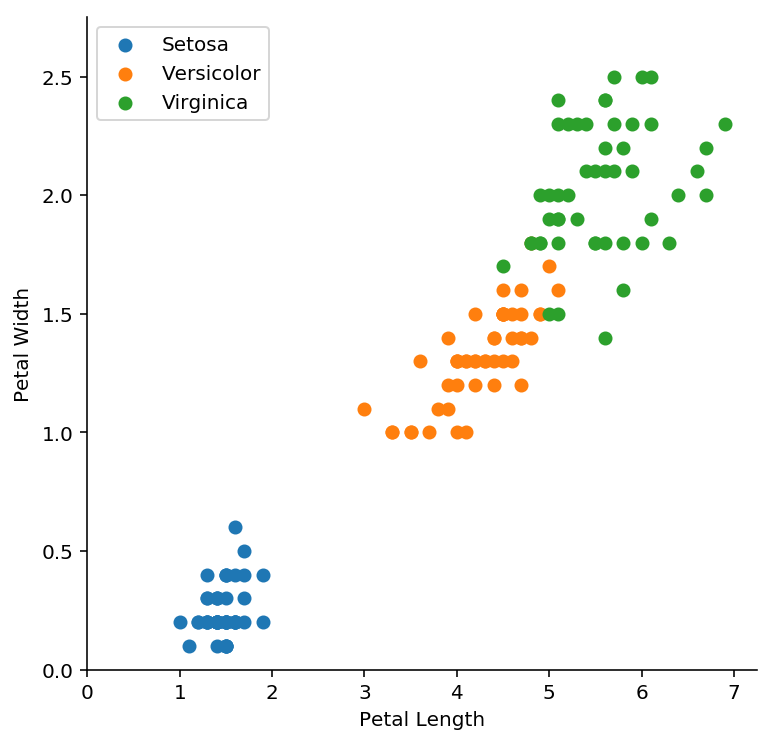

In [3]:
# plot two of the features as example- easy to visualise in 2d!
fig, ax = plt.subplots(figsize=(6,6), facecolor='white', edgecolor='white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
species_map = {0:'Setosa', 1: 'Versicolor', 2:'Virginica'}
for _ in iris_df.species.unique():
    tmp = iris_df.loc[iris_df.species == _, :]
    plt.scatter(tmp.pl.values, tmp.pw.values, label = species_map[_])

plt.xlim([0., 7.25])
plt.ylim([0., 2.75])
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend();

This gives us some intution of the task at hand: we would expect if we used petal length and width as features that Setosa should be easy to seperate from the others by splitting at petal length ~ 2.5, and the other two species will be a little more difficult to classify as there is some overlap of the groups.

## Grow trees

We instantuate a Tree object, using the Gini class as our metric.The metric is used to evaluate the quality of the splits as we grow the tree, essentially measuring the purity of the class seperation before and after a split.

In [4]:
# for initial demonstration, we will use two features to easily visualise
# the resulting classification boundaries

# initialise object
rpart1 = Tree(max_depth = 3, metric = Gini())
# grow tree
rpart1.grow_tree(df = iris_df, features = ['pl','pw'], target = 'species', prune = True)

In [5]:
# we can extract the tree from the list representation of nodes
# and gain some intution of the structure
for node in rpart1.nodes:
    if not node.pruned:
        print(node.index, node.left_child_ix, node.right_child_ix,
              node.split_feature, node.split_value, node.is_leaf)

0 1 2 pl 2.45 False
1 None None None None True
2 3 8 pw 1.75 False
3 4 7 pl 5.35 False
4 5 6 pl 3.15 True
7 None None None None True
8 9 12 pl 6.8 False
9 10 11 pl 6.65 True
12 None None None None True


### Classification boundaries

To visualise the classification boundaries we have generated, we can build a mesh and score every point in the region using our fitted tree. I've borrowed code here from the [Scikit-Learn example gallery](http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html): 

In [6]:
xx, yy = np.meshgrid(np.arange(0., 7.25, 0.01),
                     np.arange(0., 2.75, 0.01))

grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['pl', 'pw'])
grid_df['cls_boundary'] = grid_df.apply(lambda x: rpart1.predict(x.to_dict()), axis = 1)

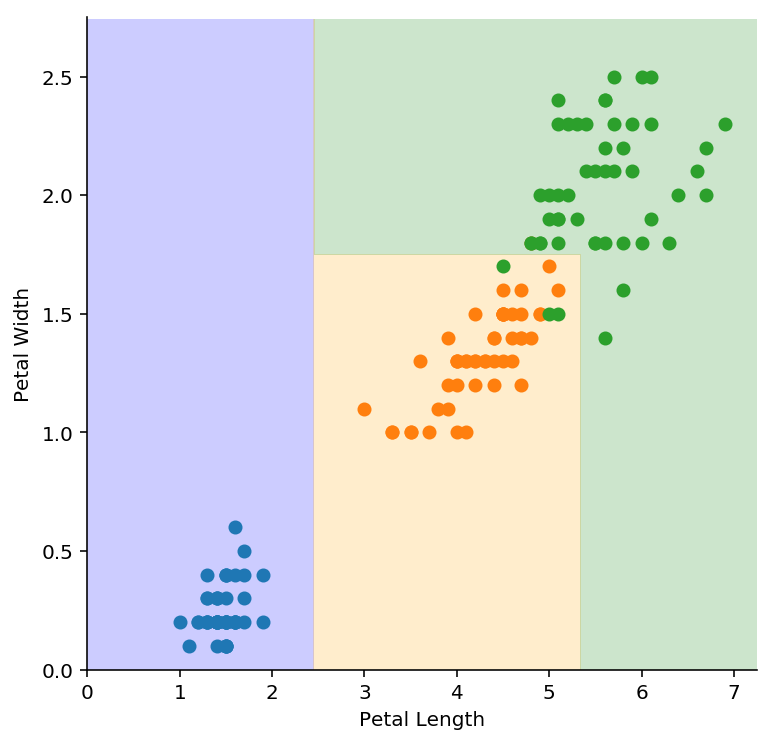

In [7]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='white', edgecolor='white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.contourf(xx, yy, grid_df.cls_boundary.values.reshape(xx.shape),
             levels = [-1, 0, 1, 2], colors = ('blue', 'orange', 'green'),
             alpha=0.2)

for _ in iris_df.species.unique():
    tmp = iris_df.loc[iris_df.species == _, :]
    plt.scatter(tmp.pl.values, tmp.pw.values)

plt.xlim([0,7.25])
plt.ylim([0, 2.75])
plt.xlabel('Petal Length')
plt.ylabel('Petal Width');

## Higher dimensional model

We can quickly run with more features to demonstrate the model's ability to generalise to >2 features.

I'm going to do a quick train/test split of my data to demonstrate that the model can be applied to new samples, however I wont bother setting up cross validation or doing any hyperparameter selection. The purpose of this post is to demonstrate a quick and instructive implementation of a classification tree: if you want to build a model for more serious applications, I suggest using the DecisionTreeClassifier class available in Scikit-Learn.

In [8]:
# get dataframe indices for a 70-30 train test split
train_ix, test_ix = train_test_split(iris_df.index.values, test_size = 0.3)

# grow tree using all features
rpart2 = Tree(max_depth = 4, metric = Gini())
rpart2.grow_tree(df = iris_df.iloc[train_ix], features = ['pl','pw', 'sl', 'sw'], target = 'species')

In [9]:
for node in rpart2.nodes:
    if not node.pruned:
        print(node.index, node.left_child_ix, node.right_child_ix,
              node.split_feature, node.split_value, node.is_leaf)

0 1 2 pl 2.6 False
1 None None None None True
2 3 10 pw 1.65 False
3 4 9 pl 5.35 False
4 5 6 pl 3.4 False
5 None None None None True
6 7 8 pl 3.55 True
9 None None None None True
10 11 12 pl 4.65 False
11 None None None None True
12 13 16 pl 6.75 False
13 14 15 pl 6.5 True
16 None None None None True


We that sepal width is never selected for a split, and can count how many times the other features are choses. This can be extended into the notion of features importance, following the intuition features can be ranked by the number of times they are selected to split on.

### Test set performance

We can quickly predict on our holdout samples, and calculate the confusion matrix using from sklearn.metrics.confusion_matrix

In [10]:
output_test = iris_df.iloc[test_ix].copy()
output_test['prediction'] = output_test.apply(lambda x: rpart2.predict(x.to_dict()), axis = 1)

confusion_matrix(output_test.species.values, output_test.prediction.values)

array([[16,  0,  0],
       [ 0, 16,  1],
       [ 0,  1, 11]])

As expected, our model performs very well for class 0 (setosa), and produces some misclassification errors due to the partial overlap in feature space of the other two species.